<a href="https://colab.research.google.com/github/Billu98/Spectrain-seminar-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Locating the files stored in google colab

In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from spectrain import Spectrain


## Checking if the files are accessible or not

In [3]:
!python /content/drive/MyDrive/Colab\ Notebooks/runtime.py

abc


## A code to use builtin spectrain algorithm to predict the future weights
 Not important because the task is to implement it by yourself.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def spectral_decomposition(weight):
    U, S, V = torch.svd(weight)
    return U, S, V

def predict_future_weights(U, S, V, steps=1):
    S_future = S * (1 + 0.01 * steps)
    weight_future = torch.mm(U, torch.mm(torch.diag(S_future), V.t()))
    return weight_future

model = SimpleNet().cuda()

U1, S1, V1 = spectral_decomposition(model.fc1.weight.data)
U2, S2, V2 = spectral_decomposition(model.fc2.weight.data)

future_steps = 5
predicted_weight1 = predict_future_weights(U1, S1, V1, future_steps)
predicted_weight2 = predict_future_weights(U2, S2, V2, future_steps)

model.fc1.weight.data = predicted_weight1
model.fc2.weight.data = predicted_weight2

stream1 = torch.cuda.Stream()
stream2 = torch.cuda.Stream()

# Create dummy inputs
inputs = torch.randn(64, 10).cuda()

# Perform forward pass using CUDA streams
with torch.cuda.stream(stream1):
    x1 = torch.relu(model.fc1(inputs))

with torch.cuda.stream(stream2):
    x2 = model.fc2(x1)

torch.cuda.synchronize(stream1)
torch.cuda.synchronize(stream2)

print("Predicted outputs:", x2)


Predicted outputs: tensor([[-0.5024],
        [ 0.0531],
        [ 0.2487],
        [-0.2076],
        [-0.5170],
        [-0.2433],
        [-0.4170],
        [-0.0278],
        [-0.2891],
        [ 0.0064],
        [-0.0862],
        [-0.0447],
        [-0.1076],
        [-0.3619],
        [-0.1941],
        [-0.3887],
        [-0.0023],
        [-0.1537],
        [-0.2026],
        [-0.0891],
        [-0.2318],
        [ 0.1515],
        [-0.1306],
        [-0.0575],
        [-0.6073],
        [-0.2937],
        [ 0.2329],
        [-0.2999],
        [ 0.0437],
        [-0.4321],
        [-0.6771],
        [-0.1316],
        [-0.4968],
        [-0.3948],
        [-0.1600],
        [ 0.1826],
        [-0.0385],
        [-0.1738],
        [-0.4315],
        [ 0.0658],
        [-0.5757],
        [-0.1520],
        [-0.4044],
        [ 0.2976],
        [ 0.1314],
        [-0.0248],
        [-0.3043],
        [-0.0242],
        [ 0.4460],
        [-0.3966],
        [ 0.1550],
        [-0.

## Cheking if cuda is available and performing simple calculation

In [5]:
import torch
import numpy as np

# Check PyTorch and CUDA installation
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

# Create a simple tensor and perform a CUDA operation
a = torch.tensor([1.0, 2.0, 3.0], device='cuda')
print("Tensor on GPU:", a)


PyTorch version: 2.3.0+cu121
CUDA available: True
Tensor on GPU: tensor([1., 2., 3.], device='cuda:0')


## Creating dummy dataset with 100,10 and training using Spectrain (CUDA Streams).

## Model used:
             --> Simple model with two hidden layers.

/content/drive/MyDrive/Colab Notebooks/spectrain.py:84: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1578.)
  p.data.add_(-group['lr'], torch.mul(version_diff, d_p))


Epoch [1/5], Loss: 1.0832230389118194
Epoch [2/5], Loss: 1.0318171739578248
Epoch [3/5], Loss: 1.0091579228639602
Epoch [4/5], Loss: 0.9866100072860717
Epoch [5/5], Loss: 0.9681657046079636


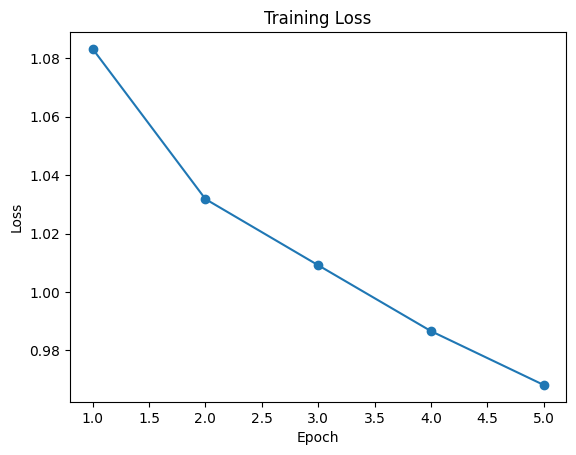

Training complete.


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.distributed as dist
import matplotlib.pyplot as plt

def initialize_process_group():
    if not dist.is_initialized():
        os.environ['RANK'] = '0'
        os.environ['WORLD_SIZE'] = '1'
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group(backend='gloo', init_method='env://')

initialize_process_group()

from spectrain import Spectrain

# Define a simple neural network
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create a dummy dataset
x = torch.randn(100, 10)
y = torch.randn(100, 1)
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

model = SimpleModel().cuda()
criterion = nn.MSELoss().cuda()

optimizer = Spectrain(model.parameters(), lr=0.01)

num_epochs = 5
losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.cuda(), targets.cuda()

        # Create CUDA streams for each part of the model
        stream1 = torch.cuda.Stream()
        stream2 = torch.cuda.Stream()

        with torch.cuda.stream(stream1):
            optimizer.zero_grad()

            # Forward pass first part of the model
            outputs = model.fc1(inputs)
            outputs = model.relu(outputs)

        with torch.cuda.stream(stream2):
            # Forward pass second part of the model
            with torch.cuda.stream(stream1):
                outputs = outputs.cuda(non_blocking=True)
            outputs = model.fc2(outputs)

        torch.cuda.synchronize(stream1)
        torch.cuda.synchronize(stream2)

        loss = criterion(outputs, targets)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}")

plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

print("Training complete.")


## Creating dummy dataset with 100,10 and training upon GPU as well as CUDA Streams (Spectrain) to compare the latency.

## Model used:
             --> Simple model with two hidden layers.

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.distributed as dist
import matplotlib.pyplot as plt
import time

def initialize_process_group():
    if not dist.is_initialized():
        os.environ['RANK'] = '0'
        os.environ['WORLD_SIZE'] = '1'
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group(backend='gloo', init_method='env://')

initialize_process_group()
from spectrain import Spectrain
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Create a dummy dataset
x = torch.randn(100, 10)
y = torch.randn(100, 1)
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

num_epochs = 5

# Function to train the model using standard GPU training
def train_standard_gpu(model, criterion, optimizer, dataloader):
    start_time = time.time()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()


            optimizer.step()
    end_time = time.time()
    return end_time - start_time

# Function to train the model using CUDA streams and SpecTrain
def train_cuda_streams_spectrain(model, criterion, optimizer, dataloader):
    start_time = time.time()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()

            stream1 = torch.cuda.Stream()
            stream2 = torch.cuda.Stream()

            with torch.cuda.stream(stream1):

                optimizer.zero_grad()

                outputs = model.fc1(inputs)
                outputs = model.relu(outputs)

            with torch.cuda.stream(stream2):

                with torch.cuda.stream(stream1):
                    outputs = outputs.cuda(non_blocking=True)
                outputs = model.fc2(outputs)

            torch.cuda.synchronize(stream1)
            torch.cuda.synchronize(stream2)

            loss = criterion(outputs, targets)

            loss.backward()

            optimizer.step()
    end_time = time.time()
    return end_time - start_time

model_standard = SimpleModel().cuda()
criterion_standard = nn.MSELoss().cuda()
optimizer_standard = optim.SGD(model_standard.parameters(), lr=0.01)

standard_gpu_training_time = train_standard_gpu(model_standard, criterion_standard, optimizer_standard, dataloader)

model_streams = SimpleModel().cuda()
criterion_streams = nn.MSELoss().cuda()
optimizer_streams = Spectrain(model_streams.parameters(), lr=0.01)

cuda_streams_training_time = train_cuda_streams_spectrain(model_streams, criterion_streams, optimizer_streams, dataloader)

print(f"Standard GPU Training Time: {standard_gpu_training_time:.4f} seconds")
print(f"CUDA Streams with SpecTrain Training Time: {cuda_streams_training_time:.4f} seconds")
print(f"Speedup: {standard_gpu_training_time / cuda_streams_training_time:.2f}x")


Standard GPU Training Time: 0.1047 seconds
CUDA Streams with SpecTrain Training Time: 0.0904 seconds
Speedup: 1.16x


## Models Used:
              CNN and FC
## Dataset Used:
              CIFAR-10

## Main idea
            To train CNN and FC on CIFAR-10 to compare the training times

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.distributed as dist
import matplotlib.pyplot as plt
import time

def initialize_process_group():
    if not dist.is_initialized():
        os.environ['RANK'] = '0'
        os.environ['WORLD_SIZE'] = '1'
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group(backend='gloo', init_method='env://')

initialize_process_group()

from spectrain import Spectrain

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Define the fully connected model
class FCModel(nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 5

# Function to train the model using standard GPU training
def train_standard_gpu(model, criterion, optimizer, dataloader):
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()

            optimizer.step()
    end_time = time.time()
    return end_time - start_time

# Function to train the model using CUDA streams and SpecTrain
def train_cuda_streams_spectrain(model, criterion, optimizer, dataloader):
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()

            # Create CUDA streams for each part of the model
            stream1 = torch.cuda.Stream()
            stream2 = torch.cuda.Stream()

            with torch.cuda.stream(stream1):
                optimizer.zero_grad()

                # Forward pass first part of the model
                if isinstance(model, CNNModel):
                    outputs = model.conv1(inputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = model.conv2(outputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = nn.MaxPool2d(2)(outputs)
                    outputs = model.dropout1(outputs)
                else:
                    outputs = torch.flatten(inputs, 1)
                    outputs = model.fc1(outputs)
                    outputs = nn.ReLU()(outputs)

            with torch.cuda.stream(stream2):
                # Forward pass second part of the model
                with torch.cuda.stream(stream1):
                    outputs = outputs.cuda(non_blocking=True)
                if isinstance(model, CNNModel):
                    outputs = torch.flatten(outputs, 1)
                    outputs = model.fc1(outputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = model.dropout2(outputs)
                    outputs = model.fc2(outputs)
                else:
                    outputs = model.fc2(outputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = model.fc3(outputs)

            torch.cuda.synchronize(stream1)
            torch.cuda.synchronize(stream2)

            loss = criterion(outputs, targets)

            loss.backward()

            optimizer.step()
    end_time = time.time()
    return end_time - start_time

models = {
    "CNN_Standard_GPU": CNNModel().cuda(),
    "CNN_CUDA_Streams": CNNModel().cuda(),
    "FC_Standard_GPU": FCModel().cuda(),
    "FC_CUDA_Streams": FCModel().cuda()
}

criterion = nn.CrossEntropyLoss().cuda()

optimizers = {
    "CNN_Standard_GPU": optim.SGD(models["CNN_Standard_GPU"].parameters(), lr=0.01),
    "CNN_CUDA_Streams": Spectrain(models["CNN_CUDA_Streams"].parameters(), lr=0.01),
    "FC_Standard_GPU": optim.SGD(models["FC_Standard_GPU"].parameters(), lr=0.01),
    "FC_CUDA_Streams": Spectrain(models["FC_CUDA_Streams"].parameters(), lr=0.01)
}

times = {
    "CNN_Standard_GPU": train_standard_gpu(models["CNN_Standard_GPU"], criterion, optimizers["CNN_Standard_GPU"], train_loader),
    "CNN_CUDA_Streams": train_cuda_streams_spectrain(models["CNN_CUDA_Streams"], criterion, optimizers["CNN_CUDA_Streams"], train_loader),
    "FC_Standard_GPU": train_standard_gpu(models["FC_Standard_GPU"], criterion, optimizers["FC_Standard_GPU"], train_loader),
    "FC_CUDA_Streams": train_cuda_streams_spectrain(models["FC_CUDA_Streams"], criterion, optimizers["FC_CUDA_Streams"], train_loader)
}

for key in times:
    print(f"{key} Training Time: {times[key]:.4f} seconds")


Files already downloaded and verified
CNN_Standard_GPU Training Time: 77.4451 seconds
CNN_CUDA_Streams Training Time: 81.9441 seconds
FC_Standard_GPU Training Time: 74.0265 seconds
FC_CUDA_Streams Training Time: 74.4777 seconds


To Mount the Drive whenever we uploaded new dataset to google drive

In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Models Used:
              CNN and FC
## Dataset Used:
              FASIONMNIST

## Main idea
            To train CNN and FC on FASIONMNIST to compare the training times

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.distributed as dist
import matplotlib.pyplot as plt
import time
from spectrain import Spectrain

def initialize_process_group():
    if not dist.is_initialized():
        os.environ['RANK'] = '0'
        os.environ['WORLD_SIZE'] = '1'
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group(backend='gloo', init_method='env://')

initialize_process_group()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Define the fully connected model
class FCModel(nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.fc3(x)
        return x

num_epochs = 5

# Function to train the model using standard GPU training
def train_standard_gpu(model, criterion, optimizer, dataloader):
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()

            optimizer.step()
    end_time = time.time()
    return end_time - start_time

# Function to train the model using CUDA streams and SpecTrain
def train_cuda_streams_spectrain(model, criterion, optimizer, dataloader):
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()

            stream1 = torch.cuda.Stream()
            stream2 = torch.cuda.Stream()

            with torch.cuda.stream(stream1):
                optimizer.zero_grad()

                # Forward pass first part of the model
                if isinstance(model, CNNModel):
                    outputs = model.conv1(inputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = model.conv2(outputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = nn.MaxPool2d(2)(outputs)
                    outputs = model.dropout1(outputs)
                else:
                    outputs = torch.flatten(inputs, 1)
                    outputs = model.fc1(outputs)
                    outputs = nn.ReLU()(outputs)

            with torch.cuda.stream(stream2):
                # Forward pass second part of the model
                with torch.cuda.stream(stream1):
                    outputs = outputs.cuda(non_blocking=True)
                if isinstance(model, CNNModel):
                    outputs = torch.flatten(outputs, 1)
                    outputs = model.fc1(outputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = model.dropout2(outputs)
                    outputs = model.fc2(outputs)
                else:
                    outputs = model.fc2(outputs)
                    outputs = nn.ReLU()(outputs)
                    outputs = model.fc3(outputs)

            torch.cuda.synchronize(stream1)
            torch.cuda.synchronize(stream2)

            loss = criterion(outputs, targets)

            loss.backward()

            optimizer.step()
    end_time = time.time()
    return end_time - start_time

models = {
    "CNN_Standard_GPU": CNNModel().cuda(),
    "CNN_CUDA_Streams": CNNModel().cuda(),
    "FC_Standard_GPU": FCModel().cuda(),
    "FC_CUDA_Streams": FCModel().cuda()
}

criterion = nn.CrossEntropyLoss().cuda()

optimizers = {
    "CNN_Standard_GPU": optim.SGD(models["CNN_Standard_GPU"].parameters(), lr=0.01),
    "CNN_CUDA_Streams": Spectrain(models["CNN_CUDA_Streams"].parameters(), lr=0.01),
    "FC_Standard_GPU": optim.SGD(models["FC_Standard_GPU"].parameters(), lr=0.01),
    "FC_CUDA_Streams": Spectrain(models["FC_CUDA_Streams"].parameters(), lr=0.01)
}

times = {
    "CNN_Standard_GPU": train_standard_gpu(models["CNN_Standard_GPU"], criterion, optimizers["CNN_Standard_GPU"], train_loader),
    "CNN_CUDA_Streams": train_cuda_streams_spectrain(models["CNN_CUDA_Streams"], criterion, optimizers["CNN_CUDA_Streams"], train_loader),
    "FC_Standard_GPU": train_standard_gpu(models["FC_Standard_GPU"], criterion, optimizers["FC_Standard_GPU"], train_loader),
    "FC_CUDA_Streams": train_cuda_streams_spectrain(models["FC_CUDA_Streams"], criterion, optimizers["FC_CUDA_Streams"], train_loader)
}

for key in times:
    print(f"{key} Training Time: {times[key]:.4f} seconds")


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

100%|██████████| 26421880/26421880 [00:00<00:00, 98168811.53it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 3066506.88it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 36772564.19it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


100%|██████████| 5148/5148 [00:00<00:00, 23546648.85it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

CNN_Standard_GPU Training Time: 78.5017 seconds
CNN_CUDA_Streams Training Time: 82.3510 seconds
FC_Standard_GPU Training Time: 74.2794 seconds
FC_CUDA_Streams Training Time: 75.9186 seconds


## Models Used:
              ResNet and VGG
## Dataset Used:
              CIFAR-10

## Main idea
            To train CNN and FC on CIFAR-10 to compare the training times

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.distributed as dist
import matplotlib.pyplot as plt
import time

def initialize_process_group():
    if not dist.is_initialized():
        os.environ['RANK'] = '0'
        os.environ['WORLD_SIZE'] = '1'
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        dist.init_process_group(backend='gloo', init_method='env://')

initialize_process_group()

from spectrain import Spectrain

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_epochs = 5

# Function to train the model using standard GPU training
def train_standard_gpu(model, criterion, optimizer, dataloader):
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()

            optimizer.step()
    end_time = time.time()
    return end_time - start_time

# Function to train the model using CUDA streams and SpecTrain
def train_cuda_streams_spectrain(model, criterion, optimizer, dataloader):
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataloader:
            inputs, targets = inputs.cuda(), targets.cuda()


            stream1 = torch.cuda.Stream()
            stream2 = torch.cuda.Stream()

            with torch.cuda.stream(stream1):

                optimizer.zero_grad()

                # Forward pass first part of the model
                if isinstance(model, models.VGG):
                    outputs = model.features(inputs)
                else:
                    outputs = model.conv1(inputs)
                    outputs = model.bn1(outputs)
                    outputs = model.relu(outputs)
                    outputs = model.maxpool(outputs)
                    outputs = model.layer1(outputs)
                    outputs = model.layer2(outputs)
                    outputs = model.layer3(outputs)
                    outputs = model.layer4(outputs)

            with torch.cuda.stream(stream2):
                # Forward pass second part of the model
                with torch.cuda.stream(stream1):
                    outputs = outputs.cuda(non_blocking=True)
                if isinstance(model, models.VGG):
                    outputs = model.avgpool(outputs)
                    outputs = torch.flatten(outputs, 1)
                    outputs = model.classifier(outputs)
                else:
                    outputs = model.avgpool(outputs)
                    outputs = torch.flatten(outputs, 1)
                    outputs = model.fc(outputs)


            torch.cuda.synchronize(stream1)
            torch.cuda.synchronize(stream2)


            loss = criterion(outputs, targets)


            loss.backward()


            optimizer.step()
    end_time = time.time()
    return end_time - start_time

models_dict = {
    "ResNet_Standard_GPU": models.resnet18(pretrained=False, num_classes=10).cuda(),
    "ResNet_CUDA_Streams": models.resnet18(pretrained=False, num_classes=10).cuda(),
    "VGG_Standard_GPU": models.vgg16(pretrained=False, num_classes=10).cuda(),
    "VGG_CUDA_Streams": models.vgg16(pretrained=False, num_classes=10).cuda()
}

criterion = nn.CrossEntropyLoss().cuda()

optimizers = {
    "ResNet_Standard_GPU": optim.SGD(models_dict["ResNet_Standard_GPU"].parameters(), lr=0.01),
    "ResNet_CUDA_Streams": Spectrain(models_dict["ResNet_CUDA_Streams"].parameters(), lr=0.01),
    "VGG_Standard_GPU": optim.SGD(models_dict["VGG_Standard_GPU"].parameters(), lr=0.01),
    "VGG_CUDA_Streams": Spectrain(models_dict["VGG_CUDA_Streams"].parameters(), lr=0.01)
}

times = {
    "ResNet_Standard_GPU": train_standard_gpu(models_dict["ResNet_Standard_GPU"], criterion, optimizers["ResNet_Standard_GPU"], train_loader),
    "ResNet_CUDA_Streams": train_cuda_streams_spectrain(models_dict["ResNet_CUDA_Streams"], criterion, optimizers["ResNet_CUDA_Streams"], train_loader),
    "VGG_Standard_GPU": train_standard_gpu(models_dict["VGG_Standard_GPU"], criterion, optimizers["VGG_Standard_GPU"], train_loader),
    "VGG_CUDA_Streams": train_cuda_streams_spectrain(models_dict["VGG_CUDA_Streams"], criterion, optimizers["VGG_CUDA_Streams"], train_loader)
}

for key in times:
    print(f"{key} Training Time: {times[key]:.4f} seconds")


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet_Standard_GPU Training Time: 103.8897 seconds
ResNet_CUDA_Streams Training Time: 119.3589 seconds
VGG_Standard_GPU Training Time: 188.1575 seconds
VGG_CUDA_Streams Training Time: 264.5895 seconds
